Loading data...
Found 19 AF files
Found 16 non-AF files
Extracting features from 19 AF files...


100%|██████████| 19/19 [00:00<00:00, 27.01it/s]


Extracting features from 16 non-AF files...


100%|██████████| 16/16 [00:00<00:00, 27.38it/s]



Feature extraction completed!
Total samples: 35
AF samples: 19
Non-AF samples: 16
Number of features: 18
Features: ['mean', 'std', 'min', 'max', 'range', 'skewness', 'kurtosis', 'rms', 'num_peaks', 'mean_hr', 'std_hr', 'rmssd', 'lf_power', 'hf_power', 'lf_hf_ratio', 'dominant_freq', 'zero_crossings', 'energy']
Training set: 28 samples
Test set: 7 samples

Training Random Forest...

RANDOM FOREST RESULTS
Test AUC: 0.6667

Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.50      0.67      0.57         3
          AF       0.67      0.50      0.57         4

    accuracy                           0.57         7
   macro avg       0.58      0.58      0.57         7
weighted avg       0.60      0.57      0.57         7


Cross-validation AUC: 0.8083 (+/- 0.3636)
Cross-validation Accuracy: 0.6857 (+/- 0.2138)

Top 10 most important features:
           feature  importance
10          std_hr    0.247868
11           rmssd    0.189512
6       

C:\Users\Admin\AppData\Local\Temp\ipykernel_17508\3740573572.py:227: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot([cv_auc_scores, cv_acc_scores], labels=['AUC', 'Accuracy'])


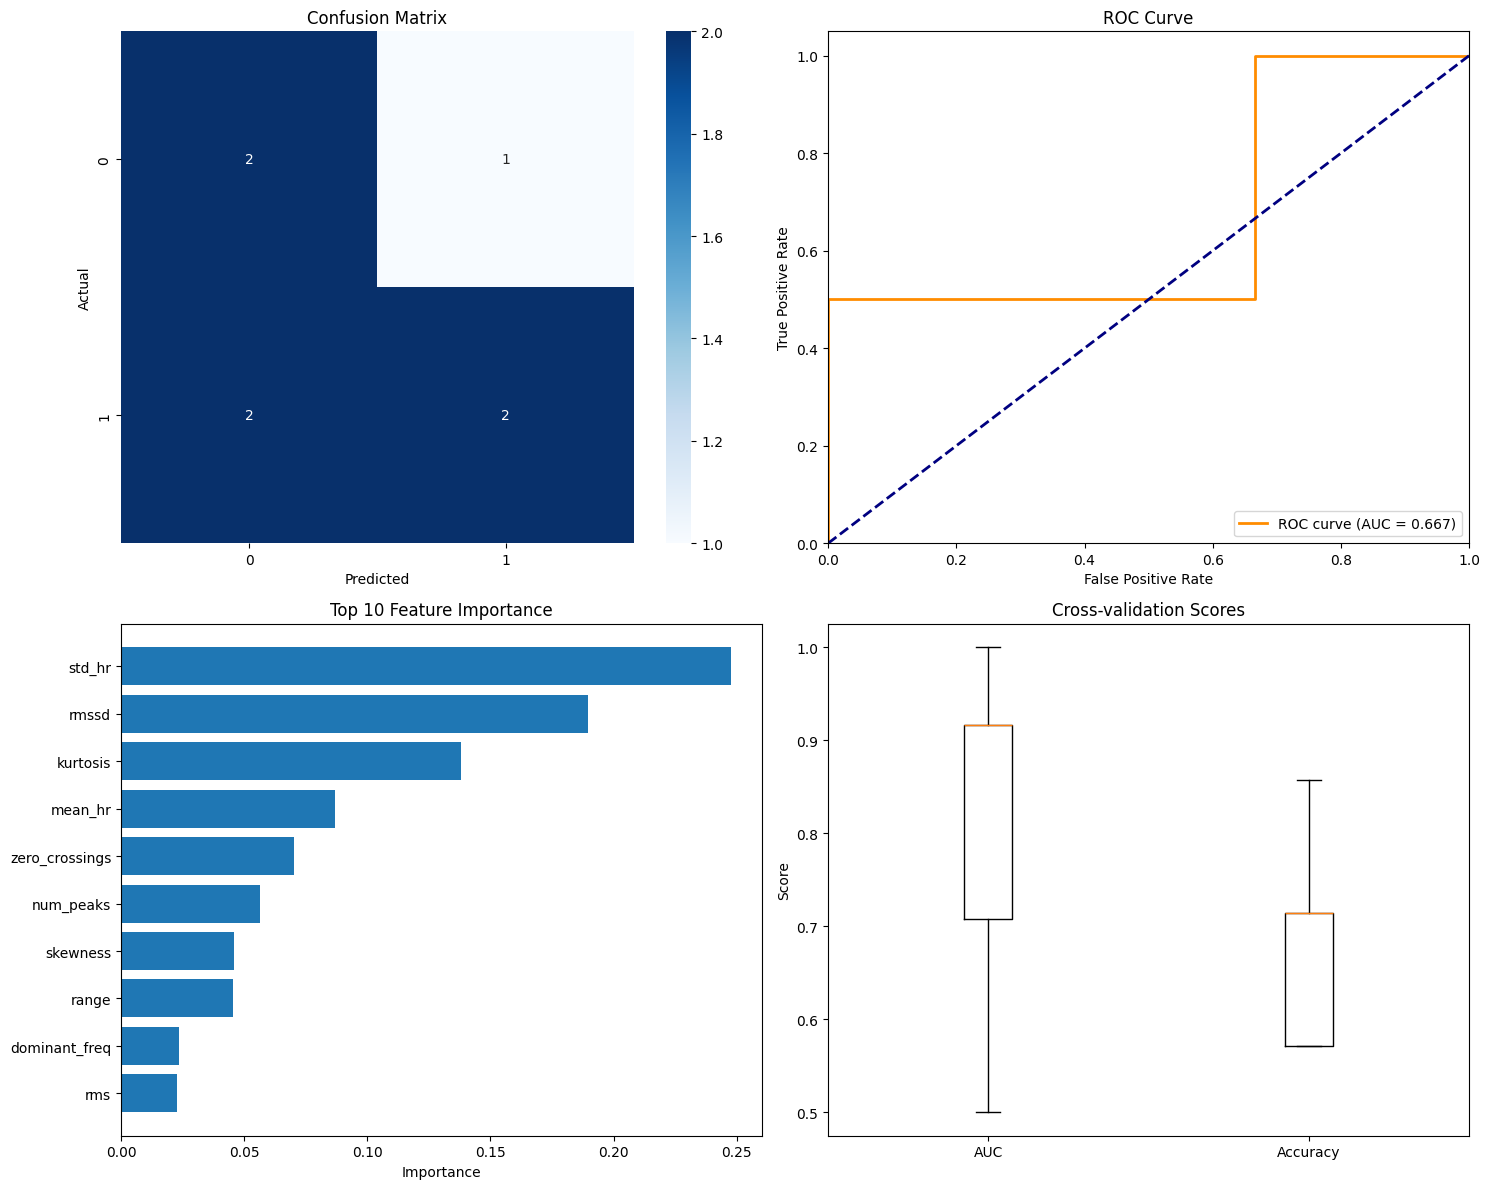


SUMMARY
Model: Random Forest
Features: 18
Total samples: 35
Test AUC: 0.6667
CV AUC: 0.8083 ± 0.1818
✅ Model performance: EXCELLENT


In [1]:
# Cell hoàn chỉnh: Load data, extract features và test Random Forest

import pandas as pd
import numpy as np
import glob
from pathlib import Path
from scipy import signal
from scipy.stats import skew, kurtosis
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dữ liệu
print("Loading data...")
def load_data(af_folder, non_af_folder):
    af_files = glob.glob(f"{af_folder}/*.csv")
    non_af_files = glob.glob(f"{non_af_folder}/*.csv")
    
    print(f"Found {len(af_files)} AF files")
    print(f"Found {len(non_af_files)} non-AF files")
    
    # Load AF data
    af_data = []
    for file in af_files:
        df = pd.read_csv(file)
        df['label'] = 1  # AF = 1
        df['file_id'] = Path(file).stem
        af_data.append(df)
    
    # Load non-AF data
    non_af_data = []
    for file in non_af_files:
        df = pd.read_csv(file)
        df['label'] = 0  # non-AF = 0
        df['file_id'] = Path(file).stem
        non_af_data.append(df)
    
    return af_data, non_af_data

# Load data
af_data, non_af_data = load_data(
    "DATA AF CSV/mimic_perform_af_csv", 
    "DATA AF CSV/mimic_perform_non_af_csv"
)

# 2. Trích xuất đặc trưng
def extract_features(ppg_signal, fs=125):
    """Simple and fast feature extraction from PPG signal"""
    features = {}
    
    # Basic statistical features
    features['mean'] = np.mean(ppg_signal)
    features['std'] = np.std(ppg_signal)
    features['min'] = np.min(ppg_signal)
    features['max'] = np.max(ppg_signal)
    features['range'] = features['max'] - features['min']
    features['skewness'] = skew(ppg_signal)
    features['kurtosis'] = kurtosis(ppg_signal)
    features['rms'] = np.sqrt(np.mean(ppg_signal**2))
    
    # Peak-based features
    try:
        peaks, _ = signal.find_peaks(ppg_signal, height=features['mean'], distance=fs//3)
        features['num_peaks'] = len(peaks)
        
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / fs
            features['mean_hr'] = 60 / np.mean(rr_intervals)
            features['std_hr'] = np.std(60 / rr_intervals)
            features['rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))
        else:
            features.update({'mean_hr': 0, 'std_hr': 0, 'rmssd': 0})
    except:
        features.update({'num_peaks': 0, 'mean_hr': 0, 'std_hr': 0, 'rmssd': 0})
    
    # Frequency domain features
    try:
        f, psd = signal.welch(ppg_signal, fs=fs, nperseg=min(256, len(ppg_signal)//4))
        
        lf_mask = (f >= 0.04) & (f < 0.15)
        hf_mask = (f >= 0.15) & (f < 0.4)
        
        features['lf_power'] = np.trapz(psd[lf_mask], f[lf_mask]) if np.any(lf_mask) else 0
        features['hf_power'] = np.trapz(psd[hf_mask], f[hf_mask]) if np.any(hf_mask) else 0
        features['lf_hf_ratio'] = features['lf_power'] / (features['hf_power'] + 1e-6)
        features['dominant_freq'] = f[np.argmax(psd)]
    except:
        features.update({'lf_power': 0, 'hf_power': 0, 'lf_hf_ratio': 0, 'dominant_freq': 0})
    
    # Other simple features
    features['zero_crossings'] = len(np.where(np.diff(np.sign(ppg_signal - features['mean'])))[0])
    features['energy'] = np.sum(ppg_signal**2)
    
    return features

def extract_all_features(data_list, label_name=""):
    feature_list = []
    print(f"Extracting features from {len(data_list)} {label_name} files...")
    
    for df in tqdm(data_list):
        try:
            features = extract_features(df['PPG'].values)
            features['label'] = df['label'].iloc[0]
            features['file_id'] = df['file_id'].iloc[0]
            feature_list.append(features)
        except Exception as e:
            print(f"Error processing file: {e}")
            continue
    
    return pd.DataFrame(feature_list)

# Extract features
af_features = extract_all_features(af_data, "AF")
non_af_features = extract_all_features(non_af_data, "non-AF")
all_features = pd.concat([af_features, non_af_features], ignore_index=True)

print(f"\nFeature extraction completed!")
print(f"Total samples: {len(all_features)}")
print(f"AF samples: {len(all_features[all_features['label']==1])}")
print(f"Non-AF samples: {len(all_features[all_features['label']==0])}")

# 3. Chuẩn bị dữ liệu cho ML
feature_columns = [col for col in all_features.columns if col not in ['label', 'file_id']]
X = all_features[feature_columns]
y = all_features['label']

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns}")

# Xử lý missing values và chuẩn hóa
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 4. Huấn luyện Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# 5. Dự đoán và đánh giá
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*50)
print("RANDOM FOREST RESULTS")
print("="*50)
print(f"Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-AF', 'AF']))

# 6. Cross-validation
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = cross_val_score(rf_model, X_scaled, y, cv=cv_folds, scoring='roc_auc')
cv_acc_scores = cross_val_score(rf_model, X_scaled, y, cv=cv_folds, scoring='accuracy')

print(f"\nCross-validation AUC: {cv_auc_scores.mean():.4f} (+/- {cv_auc_scores.std() * 2:.4f})")
print(f"Cross-validation Accuracy: {cv_acc_scores.mean():.4f} (+/- {cv_acc_scores.std() * 2:.4f})")

# 7. Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
print(feature_importance.head(10))

# 8. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")

# Feature Importance
top_features = feature_importance.head(10)
axes[1,0].barh(range(len(top_features)), top_features['importance'])
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['feature'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Top 10 Feature Importance')
axes[1,0].invert_yaxis()

# CV scores
axes[1,1].boxplot([cv_auc_scores, cv_acc_scores], labels=['AUC', 'Accuracy'])
axes[1,1].set_title('Cross-validation Scores')
axes[1,1].set_ylabel('Score')

plt.tight_layout()
plt.show()

# 9. Summary
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Model: Random Forest")
print(f"Features: {len(feature_columns)}")
print(f"Total samples: {len(all_features)}")
print(f"Test AUC: {test_auc:.4f}")
print(f"CV AUC: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")

if cv_auc_scores.mean() > 0.8:
    print("✅ Model performance: EXCELLENT")
elif cv_auc_scores.mean() > 0.7:
    print("⚠️ Model performance: GOOD")
else:
    print("❌ Model performance: NEEDS IMPROVEMENT")